# Lab Assignment Seven: Wide and Deep Network Architectures
Erik Gabrielsen, Danh Nguyen, Conrad Appel

In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

## Dataset Selection

Select a dataset identically to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification or multi-class classification.

## Grading Rubric

### Preparation (40 points total)
[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

[10 points] Identify groups of features in your data that should be combined into cross-product features. 

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (50 points total)
[20 points] Create a combined wide and deep network to classify your data using tensorflow.

[20 points] Investigate generalization performance by altering the number of layers. Try at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. 

[10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Investigate which cross-product features are most important and hypothesize why.

## Bank Marketing Data Set

For our data set we chose to use the bank marketing data set from a Portuguese banking institute. This data was collected and used to determine whether or not a client will subscribe to a term deposit based on demographical and other information of the call recipient. The training data set has 45211 instances, and there are 20 attributes associated with each instance. The following are the columns listed in order. The last column, `y`, is the column that we are attempting to predict. 

| Variable | Description   |
|------|------|
| age | numerical value of call recipients age |
| job | type of job |
| marital | individuals marital status |
| education | type of education |
| default | has a credit in default? yes or no |
| housing | has a housing loan? |
| loan | has a personal loan? |
| contact | contact communication type: cellular or telephone |
| month | last contact month |
| day_of_week | day of the week contacted |
| duration | last contact duration in seconds |
| campaign | number of contacts performed durint this campaign and for client |
| pdays |number of days passed from last contact |
| previous | number of contacts performed before this client |
| poutcome | outcome of previous campaign |
| emp.var.rate | employment variation rate |
| cons.price.idx | consumer price index |
| cons.conf.idx | consumer confidence index |
| euribor3m | euribor 3 month rate |
| nr.employed | number of employees |
| y | The variable we are trying to predict, whether or not a client has subscribed a term deposit ('yes', 'no') |
 
In the real world, this data would be used to determine which demographics to target in order to get the best response. Because making the call is a very easy task and has very little risk and no concequences when the caller does not sign up for a deposit, we will only consider true positives in our data set. These are the values that would help marketers determine who to target. The more data we recieve the better we would be able to predict. 

In [16]:
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
from sklearn import metrics as mt

tf.logging.set_verbosity(tf.logging.ERROR) # control the verbosity of tensor flow

%matplotlib inline
plt.style.use('ggplot')

In [181]:
def plot_roc(probas, y_true):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')
    
def tp_score(y_true, yhat):
    y_true = np.array(y_true) if type(y_true) == list else y_true
    yhat = np.array(yhat) if type(yhat) == list else yhat
    total1 = np.bincount(y_true)[1]
    y_true1s = np.where(y_true == 1)[0]
    yhat1s = np.where(yhat == 1)[0]
    return len(np.intersect1d(y_true1s, yhat1s))/total1

In [3]:
# http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

df_train_orig = pd.read_csv('data/bank-additional-full.csv', sep=';') # read in the csv file

df_test_orig = pd.read_csv('data/bank-additional.csv', sep=';')

df_test_orig = df_test_orig.ix[1:]
print(df_train_orig.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [4]:
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

In [5]:
# Cleaning data - getting rid of null values

df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,...,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no


## Preprocessing

Above we dropped all table data that was null-valued. 

The Bank Marketing Data has many categorical columns, so in this section we will prepare the data by transforming the categorical columns into integer numbers. Later we will one-hot encode all of these values, but for now a number representation will do. 

In [6]:
encoders = dict() 
categorical_headers = ['job','marital','day_of_week',
                       'poutcome','month','default','housing','loan','education']

for col in categorical_headers+['y']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="y":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

y_train = df_train['y'].values.astype(np.int)
y_test = df_test['y'].values.astype(np.int)
categorical_headers_ints = [x+'_int' for x in categorical_headers]

#normalize continuous attributes
numeric_headers = ["age", "campaign", "pdays", "previous"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

In [7]:
df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,y,job_int,marital_int,day_of_week_int,poutcome_int,month_int,default_int,housing_int,loan_int,education_int
0,1.533034,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,3,1,1,1,6,0,0,0,0
1,1.628993,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,7,1,1,1,6,1,0,0,3
2,-0.290186,services,married,high.school,no,yes,no,telephone,may,mon,...,0,7,1,1,1,6,0,2,0,3
3,-0.002309,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,1,1,1,6,0,0,0,1
4,1.533034,services,married,high.school,no,no,yes,telephone,may,mon,...,0,7,1,1,1,6,0,0,2,3


In [28]:
print(df_train.y.value_counts())
print(df_train.info())

0    36548
1     4640
Name: y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 30 columns):
age                41188 non-null float64
job                41188 non-null object
marital            41188 non-null object
education          41188 non-null object
default            41188 non-null object
housing            41188 non-null object
loan               41188 non-null object
contact            41188 non-null object
month              41188 non-null object
day_of_week        41188 non-null object
duration           41188 non-null int64
campaign           41188 non-null float64
pdays              41188 non-null float64
previous           41188 non-null float64
poutcome           41188 non-null object
emp.var.rate       41188 non-null float64
cons.price.idx     41188 non-null float64
cons.conf.idx      41188 non-null float64
euribor3m          41188 non-null float64
nr.employed        41188 non-null float64
y                  

## Adding Crossed Columns

Here we add some cross columns on strongly correlated data. We chose to cross the marital attribute with the housing loan attribute because of the people who are married they are more likely to have a housing loan. We also chose to cross the job attribute with education, thinking that a higher education will yield a better job. This will help us classify people who subscribe to the deposit. 

In [9]:
# Now lets create a wide model 
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers, undersample=False, oversample=False):
    # input: dataframe - what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    df_copy = deepcopy(df)
    if undersample:
        groups = df_copy.groupby('y')
        if groups.size()[0] > groups.size()[1]:
            df_copy = df_copy.drop(groups.get_group(0).index[groups.size()[1]:])
        else:
            df_copy = df_copy.drop(groups.get_group(1).index[groups.size()[0]:])
    elif oversample:
        groups = df_copy.groupby('y')
        amt_to_add = groups.size()[0] - groups.size()[1]
        df_copy = pd.concat([groups.get_group(1).sample(amt_to_add, replace=True), df_copy])
    
    # ========Process Inputs=========
    # not much changes here - we leave the numerics as tc.constants
    continuous_cols = {k: tf.constant(df_copy[k].values) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df_copy[k].size)],
                              values=df_copy[k].values,
                              dense_shape=[df_copy[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df_copy[label_header].values)
        
    return feature_cols, label

### Wide Columns Only

In [10]:
# update the model to take input features as a dictionary
def setup_wide_columns():
    # let's create the column structure that the learn API can expect
    
    wide_columns = []
    # add in each of the categorical columns
    for col in categorical_headers:
        wide_columns.append(layers.sparse_column_with_keys(col, keys=encoders[col].classes_))
        
    # also add in some specific crossed columns
    cross_columns = [('marital','housing')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
                        
    return wide_columns

In [11]:
%%time

# setup 
wide_columns = setup_wide_columns()
input_wrapper = lambda:process_input(df_train,'y',categorical_headers, numeric_headers)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)

clf = learn.LinearClassifier(feature_columns=wide_columns)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat), tp_score(y_test,yhat))

[[3635   32]
 [ 390   61]] 0.135254988914
CPU times: user 1min 33s, sys: 4.96 s, total: 1min 38s
Wall time: 44.8 s


### Deep Columns Only

In [11]:
# update the model to take input features as a dictionary
def setup_deep_columns():
    # now make up the deep columns
    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        tmp = layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        deep_columns.append(layers.embedding_column(tmp, dimension=8))
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(layers.real_valued_column(col))
                    
    return deep_columns

In [13]:
%%time 

# setup deep columns
deep_columns = setup_deep_columns()
clf = learn.DNNClassifier(feature_columns=deep_columns, hidden_units=[100, 50])

clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat), tp_score(y_test,yhat))

[[3613   54]
 [ 355   96]] 0.212860310421
CPU times: user 5min 13s, sys: 29.3 s, total: 5min 42s
Wall time: 2min


### Wide & Deep Network

We implemented a wide and deep network using tensorflow to classify our data, first with 2 layers: [100, 50]. We compared the ROC of our network under different sampling conditions to maximize our true positive rate and keep the false positive rate as low as possible. We began with the full and test data sets provided by UCI to have a simple idea of which sampling methods to use, and experimented with oversampling and undersampling the training dataset. 

In [12]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns(cross_columns=[('marital', 'housing')]):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(layers.sparse_column_with_keys(col, keys=encoders[col].classes_))
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(layers.embedding_column(wide_columns[-1], dimension=dim))
        
    # also add in some specific crossed columns
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(layers.real_valued_column(col))
                    
    return wide_columns, deep_columns

When we neither oversampled nor undersampled, our model had a low false positive rate but a very low true positive rate (.21). While our ROC graph indicates that we can have a good trade-off between our true positive rate and false positive rate, our model as is will not be good enough for predictive purposes.

In [16]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

input_wrapper = lambda:process_input(df_train,'y',categorical_headers, numeric_headers)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)
clf_fit = clf.fit(input_fn=input_wrapper, steps=2500)

CPU times: user 22min 6s, sys: 2min 12s, total: 24min 18s
Wall time: 7min 41s


In [17]:
yhat = clf.predict(input_fn=output_wrapper)
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat), tp_score(y_test,yhat))

[[3622   45]
 [ 355   96]] 0.212860310421


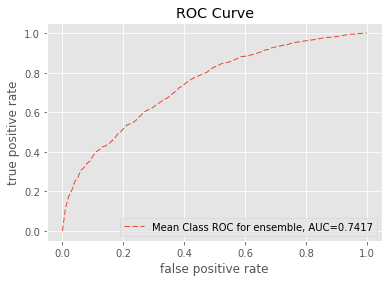

In [18]:
probas = clf.predict_proba(input_fn=output_wrapper)
probas = np.array([x for x in probas])
plot_roc(probas, y_test)

When using oversampling, we noticed a higher true positive rate (.54) even though the false positive rate is little higher, and we had a better AUC. 

In [13]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

input_wrapper = lambda:process_input(df_train,'y',categorical_headers, numeric_headers, oversample=True)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)
clf_fit = clf.fit(input_fn=input_wrapper, steps=2500)

CPU times: user 32min 34s, sys: 18min 31s, total: 51min 6s
Wall time: 2min 26s


In [14]:
yhat = clf.predict(input_fn=output_wrapper)
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat), tp_score(y_test,yhat))

[[3065  602]
 [ 201  250]] 0.554323725055


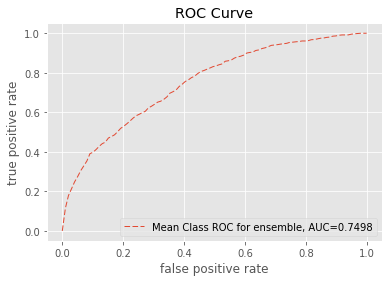

In [15]:
probas = clf.predict_proba(input_fn=output_wrapper)
probas = np.array([ x for x in probas])
plot_roc(probas, y_test)

Undersampling gave us the best true positive score (.86), but we also have the worst false positive score. Our AUC is not as great as the other models, but with this high true positive score, we decided to examing the oversampling and undersampling models further. 

In [16]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

input_wrapper = lambda:process_input(df_train,'y',categorical_headers, numeric_headers, undersample=True)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)
clf_fit = clf.fit(input_fn=input_wrapper, steps=2500)

CPU times: user 3min 58s, sys: 4min 38s, total: 8min 37s
Wall time: 30.3 s


In [17]:
yhat = clf.predict(input_fn=output_wrapper)
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat), tp_score(y_test,yhat))

[[1108 2559]
 [  61  390]] 0.864745011086


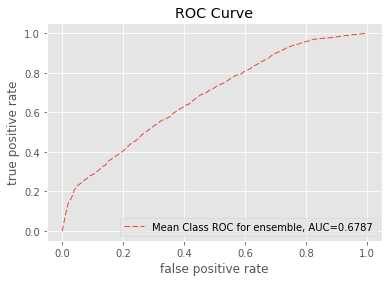

In [18]:
probas = clf.predict_proba(input_fn=output_wrapper)
probas = np.array([ x for x in probas])
plot_roc(probas, y_test)

In order to better determine the training model to use, we performed stratified shuffle split 3 times (in the interest of run time) on the full dataset for oversampling and undersampling models. This better defines our testing dataset than we were using before. By stratifying, we obtained similar ROC and mean AUC of .75 for both methods, but oversampling takes a much longer run time. 

For undersampling, we had a mean true positive rate of .603 for the three splits. For oversampling, we had a mean true positive rate of .539. Therefore, we decided to continue our analysis with the network fitted with undersampling and stratified training. 

### Undersampling

Undersampling is one method we use to work around a huge class imbalance. By undersampling, we mean that we only take a portion of the majority class so that both classes are equally representing 50% of the data set. 

[[5949 1361]
 [ 404  524]] 0.564655172414
[[6085 1225]
 [ 428  500]] 0.538793103448
[[6153 1157]
 [ 411  517]] 0.557112068966


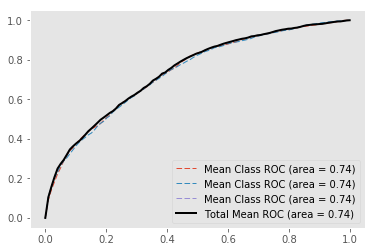

In [19]:
K = 3
cv = StratifiedShuffleSplit(n_splits=K, test_size=.2)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

for train_index, test_index in cv.split(df_train, df_train.y):
    input_wrapper = lambda:process_input(df_train.loc[train_index],'y',categorical_headers, numeric_headers, undersample=True)
    output_wrapper = lambda:process_input(df_train.loc[test_index],None,categorical_headers, numeric_headers)
    
    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    yhat = [x for x in yhat]
    print(mt.confusion_matrix(y_train[test_index],yhat), tp_score(y_train[test_index],yhat))
    
    # ROC
    probas = clf.predict_proba(input_fn=output_wrapper)
    probas = np.array([ x for x in probas])
    
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train_index])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test_index], probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC (area = %0.2f)'
                   % (roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()


### Oversampling

Oversampling is another method used to minimize the effects of the class imbalance, but it's the opposite idea of undersampling. Instead of only taking a portion of the majority class, we actually randomly sample the minority class (with replacement) so that each class takes up 50% of the training set. 

In our examples, we simply use a random sampling with replacement. However, there are other methods (SMOTE, Noisy PCA, etc) that have the potential to increase the positive effects of the oversampling.

[[6125 1185]
 [ 419  509]] 0.54849137931
[[6107 1203]
 [ 414  514]] 0.553879310345
[[6191 1119]
 [ 427  501]] 0.539870689655


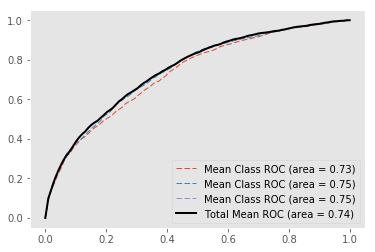

In [20]:
K = 3
cv = StratifiedShuffleSplit(n_splits=K, test_size=.2)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

for train_index, test_index in cv.split(df_train, df_train.y):
    input_wrapper = lambda:process_input(df_train.loc[train_index],'y',categorical_headers, numeric_headers, oversample=True)
    output_wrapper = lambda:process_input(df_train.loc[test_index],None,categorical_headers, numeric_headers)
    
    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]
    print(mt.confusion_matrix(y_train[test_index],yhat), tp_score(y_train[test_index],yhat))
    
    # ROC
    probas = clf.predict_proba(input_fn=output_wrapper)
    probas = np.array([ x for x in probas])
    
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train_index])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test_index],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC (area = %0.2f)'
                   % (roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()


## Altering Architecture

We continued our analysis with 3 hidden layers of [100, 50, 20] and trained using stratified shuffle split with undersampling. The ROC and AUC of 0.75 are similar to our 2 hidden layers network, and a similar mean true positive rate of .611. In the future, we may increase the number of layers and change the layer sizes to more exhaustively determine a good network size, but the 2-layer and 3-layer networks appear to perform about the same.

[[6142 1168]
 [ 393  535]] 0.57650862069
[[5224 2086]
 [ 329  599]] 0.645474137931
[[6291 1019]
 [ 457  471]] 0.507543103448


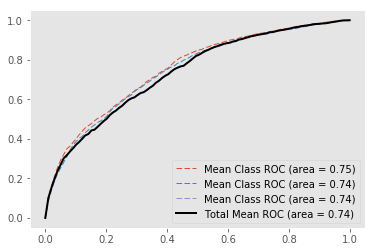

In [21]:
# attempting to statify
K = 3
cv = StratifiedShuffleSplit(n_splits=K, test_size=.2)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50, 20])

for train_index, test_index in cv.split(df_train, df_train.y):
    input_wrapper = lambda:process_input(df_train.loc[train_index],'y',categorical_headers, numeric_headers, undersample=True)
    output_wrapper = lambda:process_input(df_train.loc[test_index],None,categorical_headers, numeric_headers)
    
    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]
    print(mt.confusion_matrix(y_train[test_index],yhat), tp_score(y_train[test_index],yhat))
    
    # ROC
    probas = clf.predict_proba(input_fn=output_wrapper)
    probas = np.array([ x for x in probas])
    
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train_index])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test_index],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC (area = %0.2f)'
                   % (roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()


## Cross-Feature Importance

We then expanded the number of cross columns in our network, and determined which feature had the most impact on predictions. We looked at 3 cross features: job and education, marital and housing, and marital and education. We wanted to investigate whether people being married, having certain a job/education levels, or having housing loans would better predict if they would subscribe to a term deposit.

We cross-validated three models, looking at 2 sets of cross features at a time.

* Set 0: ('marital', 'education'), ('job', 'education') had a mean true positive rate of 0.602
* Set 1: ('marital', 'housing'), ('job', 'education') had a mean true positive rate of 0.616
* Set 2: ('marital', 'housing'), ('marital', 'education') had a mean true positive rate of 0.580

When the cross features of job and education status were removed, the model had the lowest true positive score, as well as a smaller area. This seems to indicate that job and education played an important part in the predictions. This may be due to job and education levels heavily associated with a person's income, which will affect how he or she invest money.

[('marital', 'education'), ('job', 'education')]
[[5954 1356]
 [ 415  513]] 0.552801724138
[[4705 2605]
 [ 286  642]] 0.691810344828
[[6277 1033]
 [ 435  493]] 0.53125
[('marital', 'housing'), ('job', 'education')]
[[5861 1449]
 [ 380  548]] 0.590517241379
[[6289 1021]
 [ 436  492]] 0.530172413793
[[4534 2776]
 [ 275  653]] 0.703663793103
[('marital', 'housing'), ('marital', 'education')]
[[5891 1419]
 [ 368  560]] 0.603448275862
[[6352  958]
 [ 423  505]] 0.544181034483
[[4528 2782]
 [ 268  660]] 0.711206896552


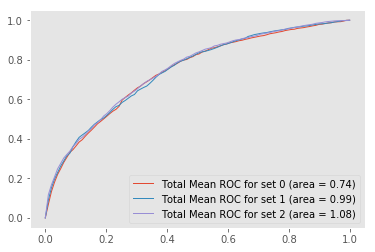

In [29]:
# attempting to stratify
K = 3

cv = StratifiedShuffleSplit(n_splits=K, test_size=.2)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


for i in range(0, 3):
    cross_columns = [('marital','housing'), ('marital','education'), ('job', 'education')]
    del cross_columns[i]
    print(cross_columns)
    
    wide_columns, deep_columns = setup_wide_deep_columns(cross_columns)
    clf = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50, 20])

    for train_index, test_index in cv.split(df_train, df_train.y):
        input_wrapper = lambda:process_input(df_train.loc[train_index],'y',categorical_headers, numeric_headers, undersample=True)
        output_wrapper = lambda:process_input(df_train.loc[test_index],None,categorical_headers, numeric_headers)

        clf.fit(input_fn=input_wrapper, steps=2500)

        yhat = clf.predict(input_fn=output_wrapper)
        # the output is now an iterable value, so we need to step over it
        yhat = [x for x in yhat]
        print(mt.confusion_matrix(y_train[test_index],yhat), tp_score(y_train[test_index],yhat))

        # ROC
        probas = clf.predict_proba(input_fn=output_wrapper)
        probas = np.array([ x for x in probas])

        perclass_mean_tpr = 0.0
        roc_auc = 0
        classes = np.unique(y_train[train_index])
        # get the mean fpr and tpr, per class
        for j in classes:
            fpr, tpr, thresholds = roc_curve(y_train[test_index],
                                             probas[:, j],
                                             pos_label=j)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0
            roc_auc += auc(fpr, tpr)

        perclass_mean_tpr /= len(classes)
        roc_auc /= len(classes)
        mean_tpr += perclass_mean_tpr
        
    mean_tpr /= K
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,perclass_mean_tpr,lw=1,label='Total Mean ROC for set %d (area = %0.2f)'
                       % (i, mean_auc))
    plt.legend(loc='best')
    plt.grid()


## Comparing to MLP

[[7218   92]
 [ 752  176]] 0.189655172414
[[7215   95]
 [ 746  182]] 0.196120689655
[[7199  111]
 [ 733  195]] 0.210129310345


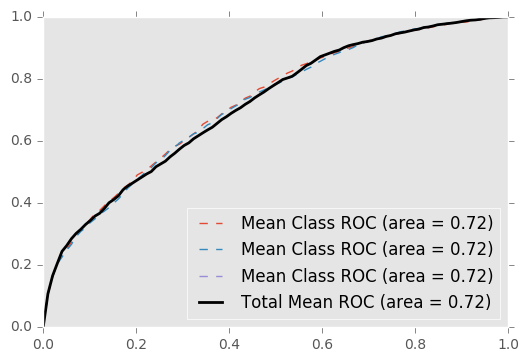

In [183]:
cv = StratifiedShuffleSplit(n_splits=3, test_size=.2)
rocs = []

new_df_train = deepcopy(df_train)
for col in new_df_train.columns:
    if col not in numeric_headers+categorical_headers+['y']:
        del new_df_train[col]
for head in categorical_headers:
    le = LabelEncoder()
    new_df_train[head] = le.fit_transform(new_df_train[head])
ys = new_df_train['y']
del new_df_train['y']

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for train_index, test_index in cv.split(df_train, df_train.y):
    train_x, train_y = new_df_train.loc[train_index], ys[train_index]
    test_x, test_y = new_df_train.loc[test_index], ys[test_index]
    p = Pipeline([('clf', MLPClassifier())])
    fitted = p.fit(train_x, train_y)
    probas = p.predict_proba(test_x)
    yhat = p.predict(test_x)
    print(mt.confusion_matrix(test_y, yhat), tp_score(test_y, yhat))
    
    # ROC
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train_index])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test_index],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC (area = %0.2f)'
                   % (roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()
